In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
ndist = 4
distances = np.array([0.0029432,0.00306911,0.00357247,0.00461673])[:ndist] # [m]
magnification = 400
detector_pixelsize = 3.03751e-6
voxelsize = detector_pixelsize/magnification*2048/n  # object voxel size

ne = n+n//4
pad = n//8
show = True

path = f'/data/vnikitin/modeling/siemens{n}'


## Read data

In [3]:
data = np.load(f'{path}/data.npy')
psi = np.load(f'{path}/psi.npy')

# Construct operators


In [4]:
def Lop(psi):
    data = cp.zeros([1,ndist, ne, ne], dtype='complex64')
    for i in range(ndist):
        psir = psi.copy()                               
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')        
        data[:, i] = psir
    return data

def LTop(data):
    psi = cp.zeros([1, ne, ne], dtype='complex64')
    for j in range(ndist):
        datar = data[:, j].copy()
        datar = GT(datar, wavelength, voxelsize, distances[j],'symmetric')        
        psi += datar
    return psi

def Cfop(e):
    res = e.copy()
    res[:,:,pad:ne-pad,pad:ne-pad] = 0
    return res

def CfTop(e):
    res = e.copy()
    res[:,:,pad:ne-pad,pad:ne-pad] = 0
    return res

def Cdop(psi):
    return psi[:,:,pad:-pad,pad:-pad]

def CdTop(psi):
    return cp.pad(psi,((0,0),(0,0),(pad,pad),(pad,pad)))


# adjoint tests
tmp = cp.array(data).copy().astype('complex64')
arr1 = cp.pad(tmp[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     

arr2 = Lop(arr1)
arr3 = LTop(arr2)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')


(1725481.5-0.0038587450981140137j)==
(1725481.5+5.481321750266943e-06j)


## Reconstruction with the CG (Carlsson) with Hessians

## Gradients

#### $$\nabla F=2 \left(L^*(C_d^*\left( C_d(L(\psi)-\tilde D\right)-C_f^*((C_f(L(\psi))-e)))\right).$$
#### where $$\tilde D = D \frac{C_dL(\psi)}{|C_dL(\psi))|}$$
#### $$\nabla_e F=-2C_f(L(\psi)-e).$$



In [5]:
def gradientF(vars,d):
    (psi,e) = (vars['psi'],vars['e'])
    Lpsi = Lop(psi)
    td = d*(Cdop(Lpsi)/np.abs(Cdop(Lpsi)))
    res = 2*LTop(CdTop(Cdop(Lpsi) - td) + CfTop(Cfop(Lpsi)-e))
    return res

def gradiente(vars):
    (psi,e) = (vars['psi'],vars['e'])
    Lpsi = Lop(psi)
    res = -2*(Cfop(Lpsi)-e)
    return res    



##### $$\frac{1}{2}\mathcal{H}|_{\psi_0}(\Delta{\psi_1},\Delta{\psi_2})= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(\Delta{\psi_1})}\overline{L(\Delta{\psi_2})})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(\Delta{\psi_1})))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(\Delta{\psi_2}))) \right\rangle$$
##### $$+\mathsf{Re}\langle \Delta{e_1},\Delta{e_2}\rangle+\mathsf{Re}\langle C_f(L(\Delta{\psi_1})),C_f(L(\Delta{\psi_2})) \rangle-\mathsf{Re}\langle C_f(L(\Delta{\psi_2})),\Delta{e_1} \rangle-\mathsf{Re}\langle C_f(L(\Delta{\psi_1})),\Delta{e_2} \rangle$$
##### $$l_0=C_d(L(\psi_0))/C_d(|L(\psi_0)|)$$
##### $$d_0=d/C_d(|L(\psi_0)|)$$


In [6]:
def hessianF(hpsi,hpsi1,hpsi2,e,de1,de2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)   
    l0 = Cdop(Lpsi)/np.abs(Cdop(Lpsi))# no conjugate for l0 here because reprod function takes care of it (reprod(a,b)=a.real*b.real+a.imag*b.imag)
    d0 = data/np.abs(Cdop(Lpsi))
    v1 = np.sum((1-d0)*reprod(Cdop(Lpsi1),Cdop(Lpsi2)))
    v2 = np.sum(d0*reprod(l0,Cdop(Lpsi1))*reprod(l0,Cdop(Lpsi2)))        
    v3 = redot(Cfop(Lpsi1)-de1,Cfop(Lpsi2)-de2)        
    return 2*(v1+v2+v3)

In [7]:
def calc_beta(vars,grads,etas,d):
    (psi,e,rho) = (vars['psi'],vars['e'],vars['rho'])
    (dpsi1,de1) = (grads['psi']*rho[0],grads['e']*rho[1])
    (dpsi2,de2) = (etas['psi']*rho[0],etas['e']*rho[1])    
    top = hessianF(psi, dpsi1, dpsi2,e,de1,de2, d)    
    bottom = hessianF(psi, dpsi2, dpsi2,e,de2,de2,d)
    return top/bottom

def calc_alpha(vars,grads,etas,d):    
    (psi,e,rho) = (vars['psi'],vars['e'],vars['rho'])
    (dpsi1,de1) = (grads['psi'],grads['e'])
    (dpsi2,de2) = (etas['psi'],etas['e'])    
    top = -redot(dpsi1,dpsi2)-redot(de1,de2)  

    (dpsi2,de2) = (etas['psi']*rho[0],etas['e']*rho[1])    
    bottom = hessianF(psi, dpsi2, dpsi2,e,de2,de2,d)
    return top/bottom, top, bottom

### Initial guess for reconstruction (Paganin)

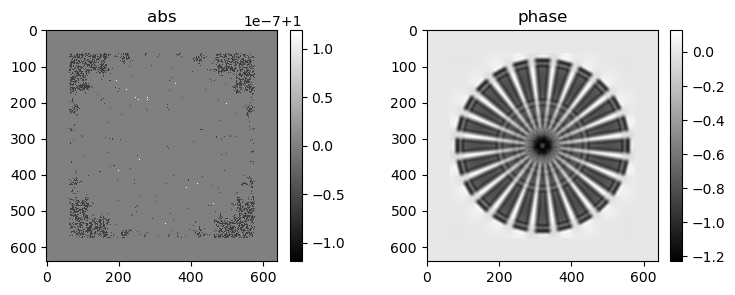

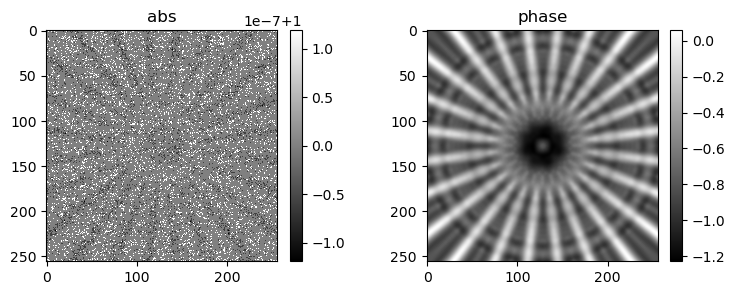

In [8]:
def rec_init(rdata):
    recMultiPaganin = cp.zeros([1,ndist,n,n],dtype='float32')
    for j in range(0,ndist):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 1e-3)    
        recMultiPaganin[:,j] = r
        
    recMultiPaganin = np.sum(recMultiPaganin,axis=1)/ndist    
    recMultiPaganin = np.exp(1j*recMultiPaganin)
    return recMultiPaganin

rec_paganin = rec_init(data)
rec_paganin = np.pad(rec_paganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'constant',constant_values=1)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)

## debug functions

In [9]:
def plot_debug2(vars,etas,top,bottom,alpha,data):
    if show==False:
        return
    (psi,e,rho) = (vars['psi'],vars['e'],vars['rho'])
    (dpsi2,de2) = (etas['psi'],etas['e'])    
    npp = 5
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        et = e+(alpha*k/(npp-1))*rho[1]*de2
        Lpsi = Lop(psit)
        fpsit = np.abs(Cdop(Lpsi))-data
        fet = Cfop(Lpsi)-et
        errt[k] = np.linalg.norm(fpsit)**2+np.linalg.norm(fet)**2
        
        
    t = alpha*(cp.arange(2*npp))/(npp-1)
    Lpsi = Lop(psi)
    fpsi = np.abs(Cdop(Lpsi))-data
    fe = Cfop(Lpsi)-e

    errt2 = np.linalg.norm(fpsi)**2+np.linalg.norm(fe)**2-top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()


def vis_debug(vars,data,i):
    mshow_polar(vars['psi'][0],show)    
    mshow_polar(vars['psi'][0,ne//2-n//4:ne//2+n//4,ne//2+n//4:ne//2+n//2+n//4],show)    
    
def err_debug(vars, grads, data):    
    (psi,e) = (vars['psi'], vars['e'])
    Lpsi = Lop(psi)
    fpsi = np.abs(Cdop(Lpsi))-data
    fe = Cfop(Lpsi)-e

    err = np.linalg.norm(fpsi)**2+np.linalg.norm(fe)**2
    
    return err

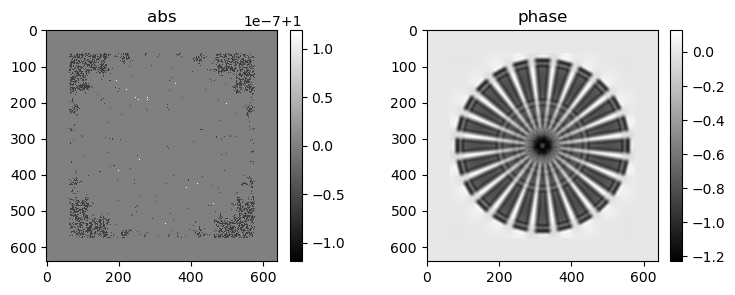

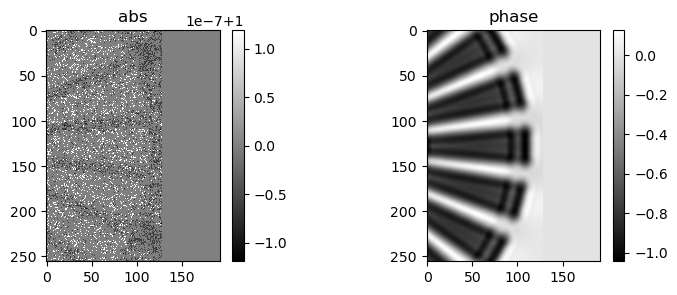

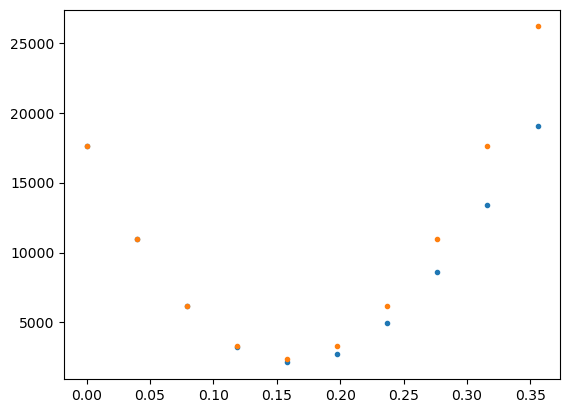

0) alpha=0.15811,[1, 2] err=2.13537e+03
32) alpha=0.19163,[1, 2] err=3.76587e+00
64) alpha=0.23449,[1, 2] err=5.04715e-01
96) alpha=0.26424,[1, 2] err=1.61920e-01


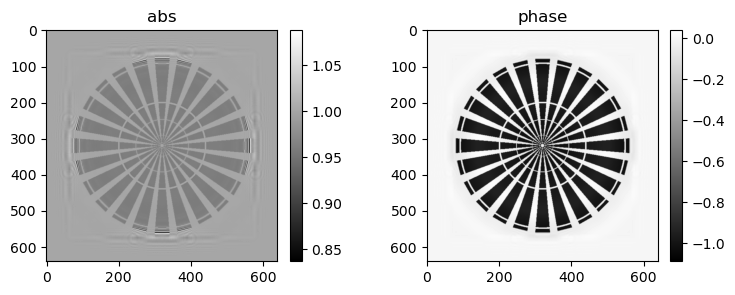

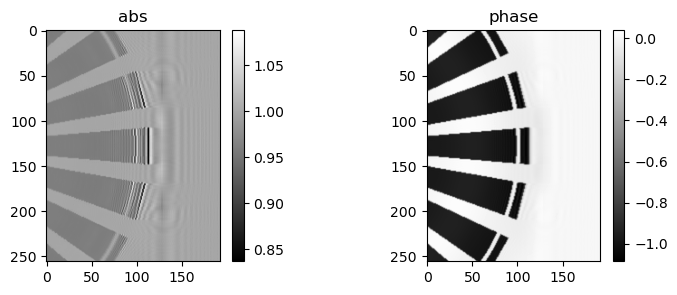

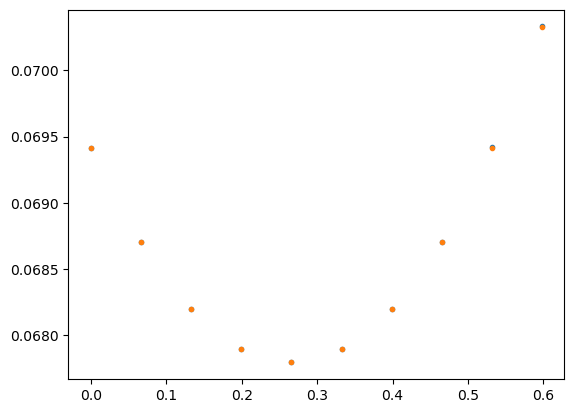

128) alpha=0.26577,[1, 2] err=6.77966e-02
160) alpha=0.22355,[1, 2] err=2.96527e-02
192) alpha=0.23508,[1, 2] err=1.84628e-02
224) alpha=0.22514,[1, 2] err=1.18462e-02


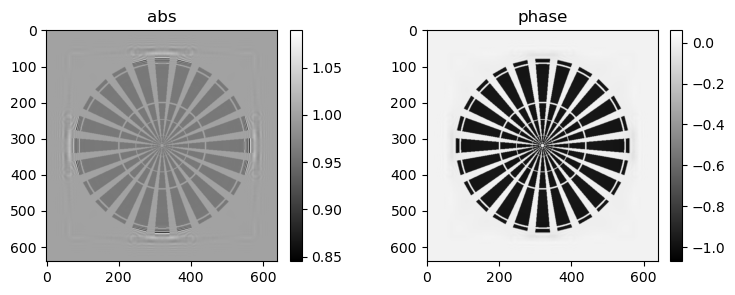

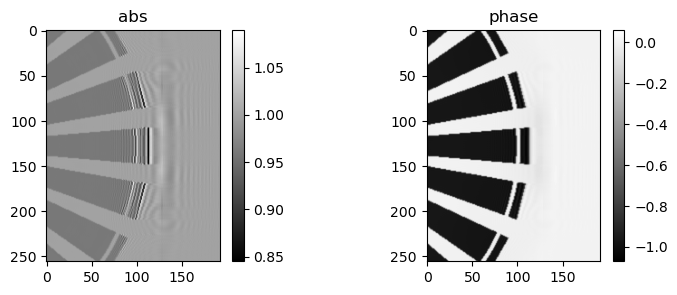

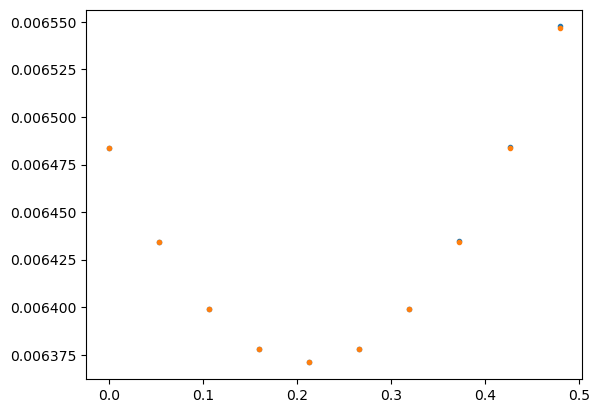

256) alpha=0.21296,[1, 2] err=6.37114e-03
288) alpha=0.19740,[1, 2] err=3.99633e-03
320) alpha=0.18282,[1, 2] err=2.79856e-03
352) alpha=0.17919,[1, 2] err=1.93795e-03


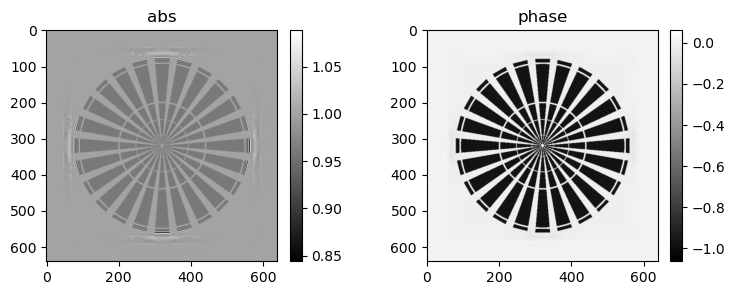

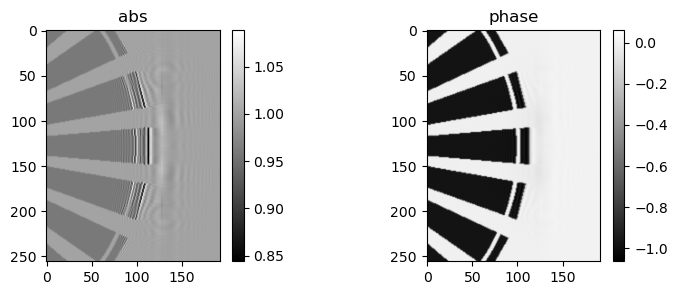

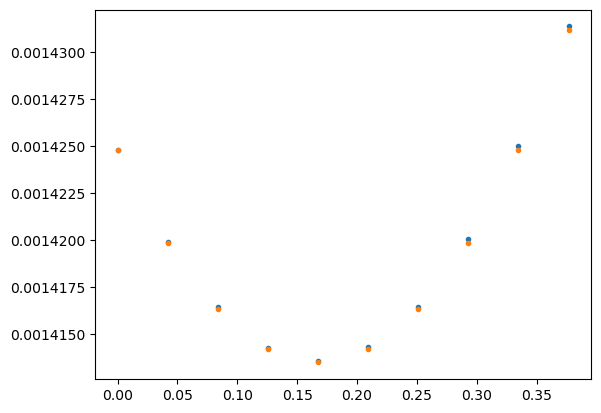

384) alpha=0.16744,[1, 2] err=1.41360e-03
416) alpha=0.15758,[1, 2] err=1.16099e-03
448) alpha=0.14862,[1, 2] err=1.00957e-03
480) alpha=0.14245,[1, 2] err=9.11744e-04


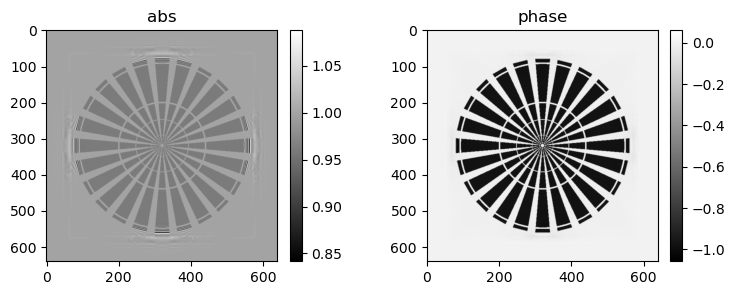

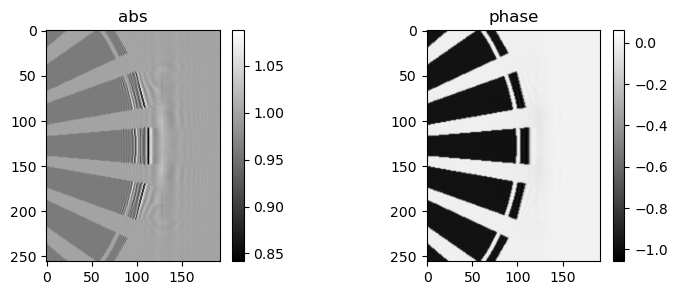

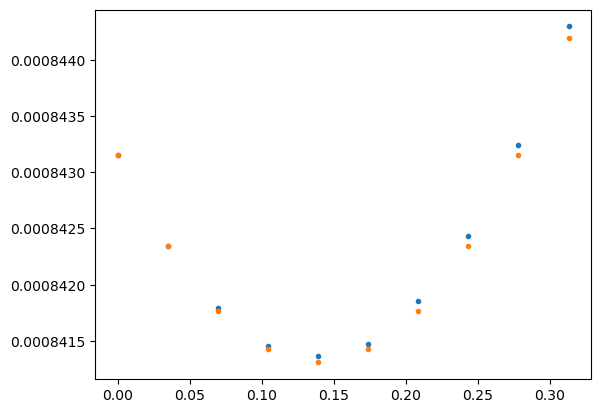

512) alpha=0.13913,[1, 2] err=8.41364e-04
544) alpha=0.13288,[1, 2] err=8.05267e-04
576) alpha=0.13331,[1, 2] err=7.83351e-04
608) alpha=0.12839,[1, 2] err=7.66240e-04


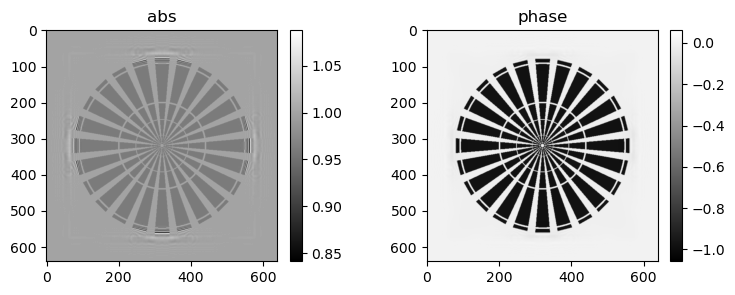

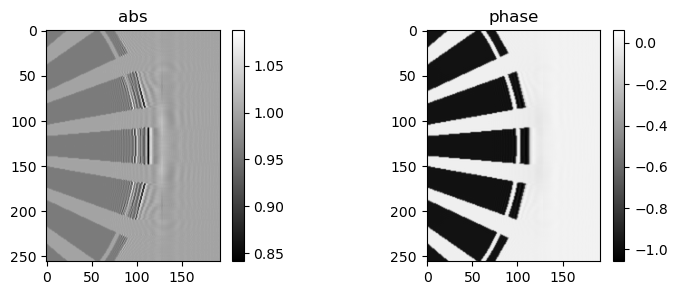

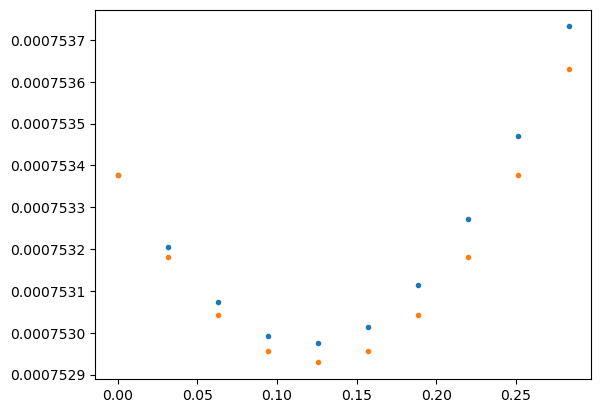

640) alpha=0.12578,[1, 2] err=7.52975e-04
672) alpha=0.12717,[1, 2] err=7.41369e-04
704) alpha=0.12605,[1, 2] err=7.32382e-04
736) alpha=0.12458,[1, 2] err=7.23343e-04


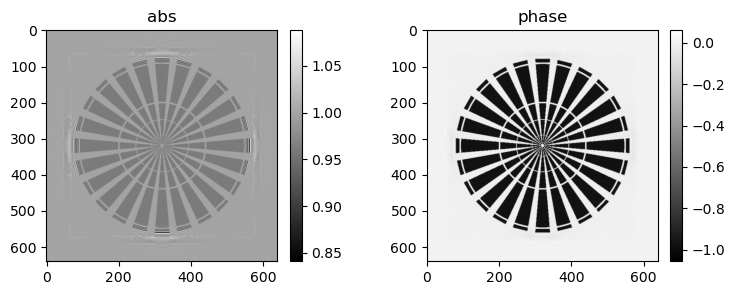

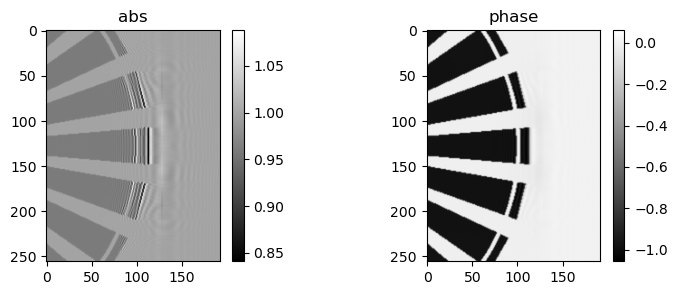

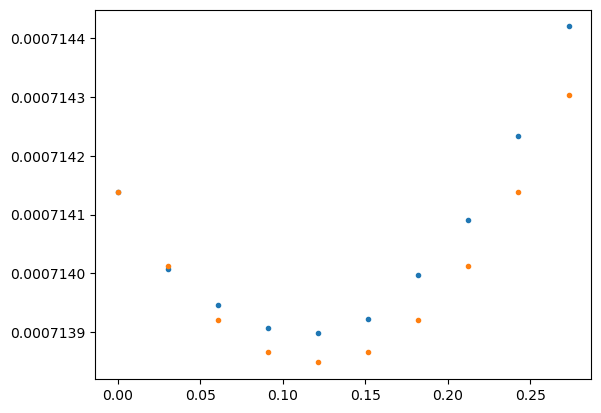

768) alpha=0.12136,[1, 2] err=7.13899e-04
800) alpha=0.12222,[1, 2] err=7.06331e-04
832) alpha=0.12149,[1, 2] err=6.98915e-04
864) alpha=0.11790,[1, 2] err=6.91701e-04


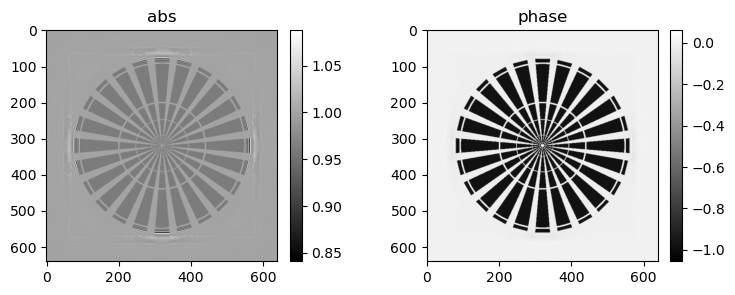

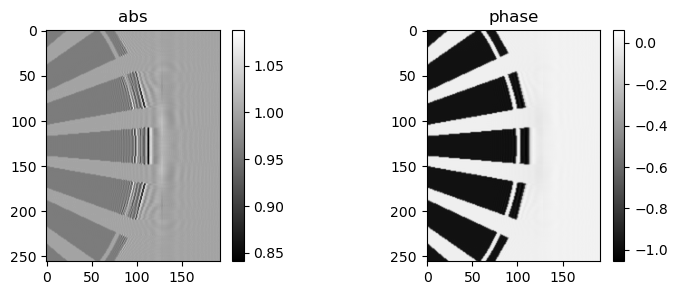

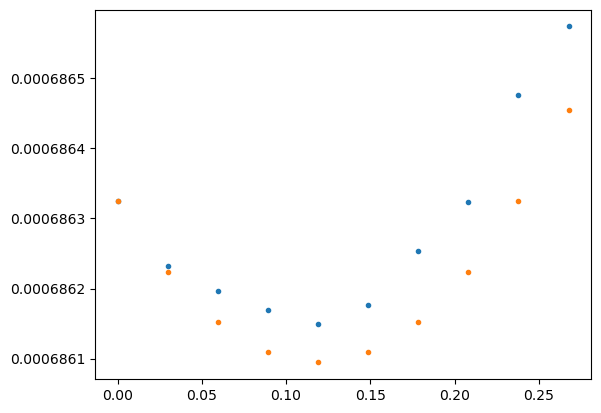

896) alpha=0.11895,[1, 2] err=6.86150e-04
928) alpha=0.11663,[1, 2] err=6.80460e-04
960) alpha=0.12057,[1, 2] err=6.74559e-04
992) alpha=0.11963,[1, 2] err=6.69224e-04


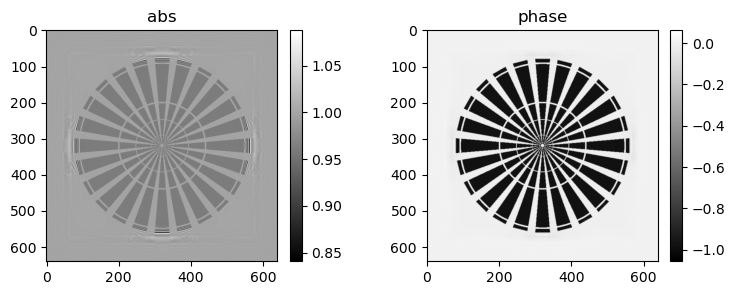

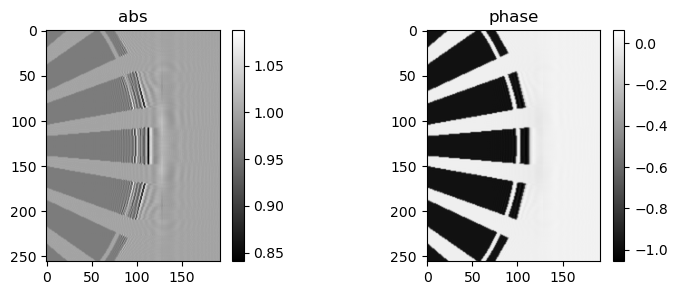

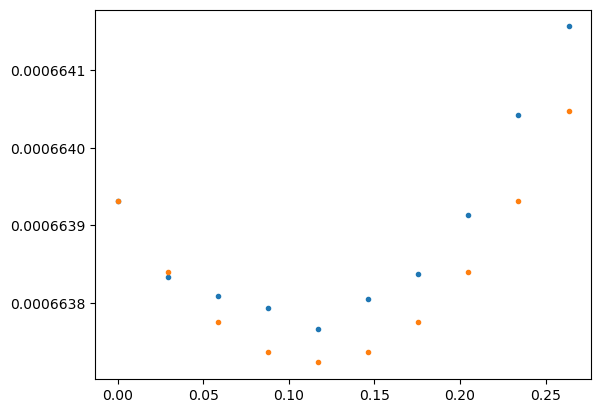

1024) alpha=0.11708,[1, 2] err=6.63767e-04


In [10]:
def cg_holo(data, vars, pars):
    
    # take sqrt of data
    data = np.sqrt(data)    
    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    

    grads ={}
    for i in range(pars['niter']):          

        # debug: visualization of reconstructions
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, data, i) 
        
        # gradients
        grads['psi'] = vars['rho'][0]*gradientF(vars,data)        
        grads['e'] = vars['rho'][1]*gradiente(vars)        

        # calc eta and beta
        if i==0:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['e'] = -grads['e']
        else:      
            beta = calc_beta(vars, grads, etas, data)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['e'] = -grads['e'] + beta*etas['e']

        # calc alpha
        alpha,top,bottom = calc_alpha(vars, grads, etas, data) 

        # debug: minimization function plot
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            plot_debug2(vars,etas,top,bottom,alpha,data)

        # update variables
        vars['psi'] += vars['rho'][0]*alpha*etas['psi']
        vars['e'] += vars['rho'][1]*alpha*etas['e']
        
        # debug: calc minimization function
        if i % pars['err_step'] == 0:
            err = err_debug(vars, grads, data)    
            print(f'{i}) {alpha=:.5f},{vars['rho']} {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha                

    return vars,erra,alphaa

vars = {}
vars['psi'] = cp.array(rec_paganin).copy()
vars['e'] = 1+0*Lop(rec_paganin)
vars['e'][:,:,pad:ne-pad,pad:ne-pad]=0
vars['rho'] = [1,2]# weights for gradients
pars = {'niter': 1025, 'err_step':32, 'vis_step': 128}

data_rec = cp.array(data)
vars,erra,alphaa = cg_holo(data_rec, vars, pars)    